In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import random
import seaborn as snx
import xgboost as xgb
random.seed(42)

from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, KFold, ShuffleSplit, StratifiedKFold, learning_curve, LearningCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb

import fcalc
from skfeature.function.similarity_based import fisher_score
# from mlxtend.feature_selection import SequentialFeatureSelector

In [8]:
os.chdir("C:/Users/HP pavilion X360/Desktop/OSDA/big_homework/")
data = pd.read_csv('sternberg_diff_data.csv', index_col = 0)
data.head()

,Fp1,Fz,F3,F7,FT9,FC5,FC1,C3,T7,CP5,...,F6,F2,AF4,AF8,TP9,TP10,Cz,target,rt,trial
0,0.000120,0.000249,0.000266,0.000320,0.000147,0.000192,0.000142,0.000087,0.000244,0.000116,...,0.000184,0.000185,0.000222,0.000307,0.000193,0.000245,0.000213,3,0.520900,1
1,0.000077,0.000254,0.000188,0.000246,0.000135,0.000126,0.000168,0.000092,0.000197,0.000109,...,0.000256,0.000282,0.000277,0.000299,0.000232,0.000291,0.000190,3,0.496360,2
2,0.000110,0.000139,0.000242,0.000183,0.000104,0.000101,0.000180,0.000082,0.000126,0.000086,...,0.000230,0.000304,0.000249,0.000423,0.000222,0.000193,0.000248,3,0.559581,3
3,0.000166,0.000274,0.000200,0.000235,0.000139,0.000087,0.000107,0.000096,0.000152,0.000086,...,0.000290,0.000294,0.000244,0.000594,0.000291,0.000264,0.000160,3,0.462914,4
4,0.000105,0.000187,0.000176,0.000260,0.000093,0.000105,0.000102,0.000060,0.000146,0.000107,...,0.000327,0.000276,0.000220,0.000494,0.000238,0.000189,0.000136,3,0.514266,5


In [9]:
data_3 = data[data.target == 3][:len(data[data.target ==15])]
data_3_15 = pd.concat([data_3, data[data.target ==15]], axis = 0)
y = data_3_15['target']
y = 1*(y==15).values
data_3_15.drop(['target', 'trial'], axis = 1, inplace = True)
X = data_3_15

In [10]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, test_size = 0.3, stratify = y)

In [42]:
stsc = StandardScaler()
stsc.fit(X_train)
train = stsc.transform(X_train)
test = stsc.transform(X_test)

kbins = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile', subsample=None).fit(train)
new_train = pd.DataFrame(kbins.transform(train), columns = X.columns)
new_test = pd.DataFrame(kbins.transform(test), columns = X.columns)

In [43]:
ohe = OneHotEncoder(drop = 'first').fit(new_train)
ohe_train = ohe.transform(new_train).toarray()
ohe_test = ohe.transform(new_test).toarray()

columns = [i + ' ' + 'q' + str(j) for i in data_3_15.columns for j in [2,3,4]]

## KNN

Best params: {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'distance'}
Accuracy: 0.7654941373534339
f1: 0.7586206896551725


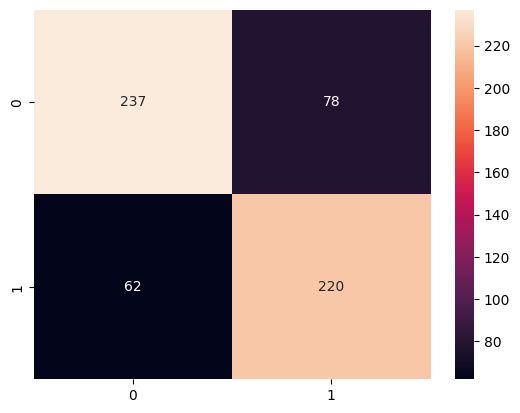

In [13]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(1, 30, 1), 'metric': ('euclidean', 'manhattan'),
             'weights':('uniform', 'distance')}
grid = GridSearchCV(knn, parameters, cv = 4)

grid.fit(train, y_train)
print(f'Best params: {grid.best_params_}')
knn_pred = KNeighborsClassifier(metric = grid.best_params_['metric'], n_neighbors = grid.best_params_['n_neighbors'],
                               weights = grid.best_params_['weights'])
knn_pred.fit(train, y_train)

y_pred = knn_pred.predict(test)

contingency_matrix = metrics.cluster.contingency_matrix(y_pred,
                                                      y_test)
snx.heatmap(contingency_matrix, annot = True, fmt='')
print(f'Accuracy: {metrics.accuracy_score(y_pred = y_pred, y_true = y_test)}')
print(f'f1: {metrics.f1_score(y_pred = y_pred, y_true = y_test)}')

## LogisticRegression

Best params: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression accuracy: 0.6800670016750419
Logistic Regression f1: 0.6583184257602862


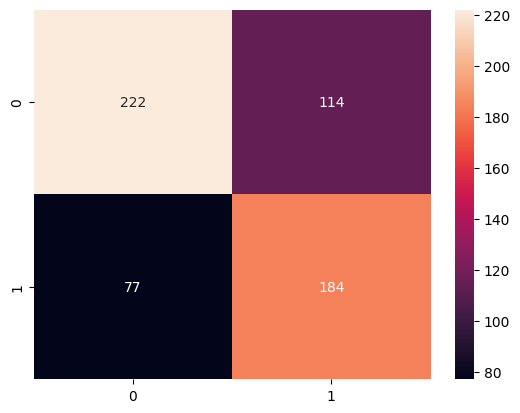

In [14]:
lr = LogisticRegression(max_iter = 10000, random_state = 42)
parameters = {'C':np.arange(0.1, 10, 1), 'penalty': ('l2', 'l1'),
             'class_weight': ['balanced'],
             'solver' : ['saga', 'liblinear']}
grid = GridSearchCV(lr, parameters, cv = 4, n_jobs = -2)

grid.fit(train, y_train)
print(f'Best params: {grid.best_params_}')
    
lr_pred = LogisticRegression(C = grid.best_params_['C'], penalty = grid.best_params_['penalty'],
                               class_weight = grid.best_params_['class_weight'],
                            solver = grid.best_params_['solver'])
lr_pred.fit(train, y_train)

y_pred = lr_pred.predict(test)

contingency_matrix = metrics.cluster.contingency_matrix(y_pred, y_test)
snx.heatmap(contingency_matrix, annot = True, fmt='')

print(f'Logistic Regression accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'Logistic Regression f1: {f1_score(y_test, y_pred)}')

## XGBoost

In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# X, y = make_classification(n_samples=500,class_sep=0.7)
clf = xgb.XGBClassifier(tree_method="hist", nfold=4, metrics = 'logloss', seed=42)
data_dmatrix = xgb.DMatrix(data=train,label=y_train)
params = {'objective':'binary:logistic','eval_metric':'logloss',
          'eta':0.01,
          'subsample':0.1}
def fit_and_score(estimator, X_train, X_test, y_train, y_test):
    """Fit the estimator on the train set and score it on both sets"""
    estimator.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    return estimator, train_score, test_score


cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=94)

In [16]:
params = {'eta':np.linspace(0.1, 1.0, 5),
          'subsample':[0.5, 0.7, 1],
          'max_depth': [1, 5, 10, 20],
          'eval_metric':['logloss'],
          'alpha':np.linspace(0, 20, 5),
         'objective':['binary:logistic']}

grid = GridSearchCV(clf, params, cv = 4,  n_jobs = -2)

grid.fit(train, y_train)
print(f'Best params: {grid.best_params_}')

C:\Users\HP pavilion X360\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:50:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "metrics", "nfold" } are not used.

  warnings.warn(smsg, UserWarning)


Best params: {'alpha': 0.0, 'eta': 0.1, 'eval_metric': 'logloss', 'max_depth': 20, 'objective': 'binary:logistic', 'subsample': 0.5}


XGB accuracy: 0.7922948073701842
XGB f1: 0.7891156462585034


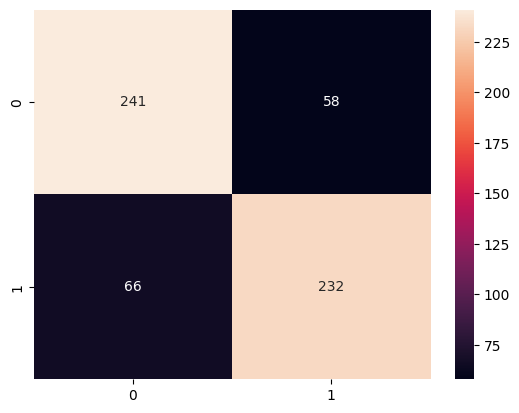

In [17]:
xgb_reg = xgb.XGBClassifier(objective='binary:logistic',
                           eval_metric = 'logloss',
                           eta = grid.best_params_['eta'],
                           subsample = grid.best_params_['subsample'],
                           max_depth = grid.best_params_['max_depth'],
                           alpha = grid.best_params_['alpha'])

xgb_reg.fit(train, y_train)
y_pred = xgb_reg.predict_proba(test)[:, 1] > .5

contingency_matrix = metrics.cluster.contingency_matrix(y_test, y_pred)
snx.heatmap(contingency_matrix, annot = True, fmt='')

print(f'XGB accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'XGB f1: {f1_score(y_test, y_pred)}')

In [20]:
print()

## Random Forest

Best params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 17, 'min_samples_split': 5}
RFT accuracy: 0.7906197654941374
RFT f1: 0.7833622183708839


<Axes: >

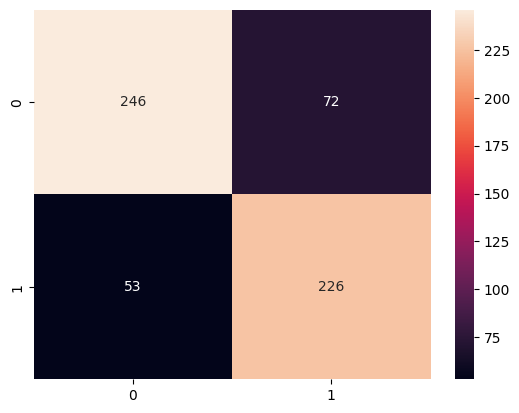

In [18]:
rfc = RandomForestClassifier(random_state = 42, n_jobs = -2)
parameters = {'max_depth':np.arange(3, 30, 2),
             'criterion':['gini', 'entropy'], 'min_samples_split': np.arange(3, 30, 2),
             'class_weight':['balanced', 'balanced_subsample']}
grid = GridSearchCV(rfc, parameters, cv = 4)

grid.fit(train, y_train)
print(f'Best params: {grid.best_params_}')
rfc_pred = RandomForestClassifier(random_state = 42, max_depth = grid.best_params_['max_depth'],
                                 criterion = grid.best_params_['criterion'],
                                 min_samples_split = grid.best_params_['min_samples_split'],
                                 class_weight = grid.best_params_['class_weight'])
rfc_pred.fit(train, y_train)
y_pred = rfc_pred.predict(test)

contingency_matrix = metrics.cluster.contingency_matrix(y_pred, y_test)

y_pred = rfc_pred.predict(test)
print(f'RFT accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'RFT f1: {f1_score(y_test, y_pred)}')
snx.heatmap(contingency_matrix, annot = True, fmt='')

## FCALC

In [124]:
best_params = dict()
kf = KFold(n_splits=4, shuffle = True, random_state=42)
for train, test in kf.split(ohe_train_sel):
    for alpha in np.arange(0, 10, 3):
        if str(alpha) not in list(best_params.keys()):
            best_params[str(alpha)]=[]
        bin_cls = fcalc.classifier.BinarizedBinaryClassifier(ohe_train_sel[train],
                                                             y_train.astype(int)[train], method = 'standard', alpha = alpha)
        # bin_cls = fcalc.classifier.BinarizedBinaryClassifier(ohe_train.toarray()[train], y_train[train], method = 'standard')
        bin_cls.predict(ohe_train_sel[test])
        f1 = f1_score(y_train.astype(int)[test], bin_cls.predictions, average = None)
        best_params[str(alpha)].append(f1)

print(best_params)

{'0': [array([0.        , 0.58823529, 0.35555556]), array([0.        , 0.60087719, 0.24369748]), array([0.        , 0.56206089, 0.29323308]), array([0.        , 0.60386473, 0.40860215])], '3': [array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.])], '6': [array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.])], '9': [array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.])]}


0.47738693467336685
[0.         0.58366801 0.3011236 ]


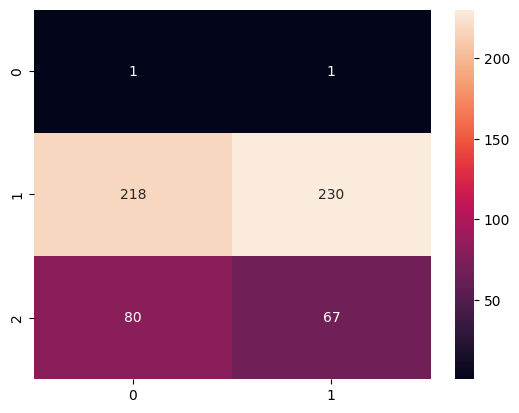

In [126]:
bin_cls = fcalc.classifier.BinarizedBinaryClassifier(ohe_train_sel, y_train, method = 'standard', alpha = 0)
bin_cls.predict(ohe_test_sel)
y_pred = bin_cls.predictions

contingency_matrix = metrics.cluster.contingency_matrix(y_pred, y_test)
snx.heatmap(contingency_matrix, annot = True, fmt='')
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average = None))

In [54]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

# common_params = {
#     "X": ohe_train_sel,
#     "y": y_train,
#     "train_sizes": np.linspace(0.1, 1.0, 5),
#     "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
#     "score_type": "both",
#     "n_jobs": 4,
#     "line_kw": {"marker": "o"},
#     "std_display_style": "fill_between",
#     "score_name": "Accuracy",
# }

# for ax_idx, estimator in enumerate([bin_cls]):
#     LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
#     handles, label = ax[ax_idx].get_legend_handles_labels()
#     ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
#     ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

In [19]:
best_params_f1 = dict()
best_params_acc = dict()

kf = KFold(n_splits=4, shuffle = True, random_state=42)
for train_id, test_id in kf.split(train):
    for alpha in np.arange(0, 10, 3):
        for method in ['standard', 'standard-support', 'standard-ratio']:
            print(f'{method}, alpha={alpha}')
            if str(alpha) not in list(best_params_f1.keys()):
                best_params_f1[f'method: {method}, alpha: {alpha}']=[]
                best_params_acc[f'method: {method}, alpha: {alpha}']=[]
            pat_cls = fcalc.classifier.PatternBinaryClassifier(train[train_id].astype(int), y_train.astype(int)[train_id], method = method, alpha = alpha)
            pat_cls.predict(train[test_id].astype(int))
            f1 = f1_score(y_train.astype(int)[test_id], pat_cls.predictions, average = None)
            acc = accuracy_score(y_train.astype(int)[test_id], pat_cls.predictions)
            best_params_f1[f'method: {method}, alpha: {alpha}'].append(f1)
            best_params_acc[f'method: {method}, alpha: {alpha}'].append(acc)

standard, alpha=0
standard-support, alpha=0
standard-ratio, alpha=0
standard, alpha=3
standard-support, alpha=3
standard-ratio, alpha=3
standard, alpha=6
standard-support, alpha=6
standard-ratio, alpha=6
standard, alpha=9
standard-support, alpha=9
standard-ratio, alpha=9
standard, alpha=0
standard-support, alpha=0
standard-ratio, alpha=0
standard, alpha=3
standard-support, alpha=3
standard-ratio, alpha=3
standard, alpha=6
standard-support, alpha=6
standard-ratio, alpha=6
standard, alpha=9
standard-support, alpha=9
standard-ratio, alpha=9
standard, alpha=0
standard-support, alpha=0
standard-ratio, alpha=0
standard, alpha=3
standard-support, alpha=3
standard-ratio, alpha=3
standard, alpha=6
standard-support, alpha=6
standard-ratio, alpha=6
standard, alpha=9
standard-support, alpha=9
standard-ratio, alpha=9
standard, alpha=0
standard-support, alpha=0
standard-ratio, alpha=0
standard, alpha=3
standard-support, alpha=3
standard-ratio, alpha=3
standard, alpha=6
standard-support, alpha=6
stan

In [24]:
best_params_f1

{'method: standard, alpha: 0': [array([0.        , 0.5398773 , 0.53614458])],
 'method: standard-support, alpha: 0': [array([0.        , 0.5578635 , 0.51410658])],
 'method: standard-ratio, alpha: 0': [array([0.66538462, 0.        ])],
 'method: standard, alpha: 3': [array([0., 0., 0.])],
 'method: standard-support, alpha: 3': [array([0.        , 0.66794626])],
 'method: standard-ratio, alpha: 3': [array([0.66538462, 0.        ])],
 'method: standard, alpha: 6': [array([0., 0., 0.])],
 'method: standard-support, alpha: 6': [array([0.        , 0.66794626])],
 'method: standard-ratio, alpha: 6': [array([0.66538462, 0.        ])],
 'method: standard, alpha: 9': [array([0., 0., 0.])],
 'method: standard-support, alpha: 9': [array([0.        , 0.66794626])],
 'method: standard-ratio, alpha: 9': [array([0.66538462, 0.        ])]}

In [29]:
train_size = learning_curve.train_sizes

In [55]:
np.unique(y_pred, return_counts= True)

(array([-1.,  0.,  1.]), array([819, 288, 173], dtype=int64))

In [ ]:
def alpha_weak(pos, neg, C=0.):
    sup_pos = 2* np.sum(pos[1] <= len(neg[0]) * C) / len(pos[0])
    sup_neg = np.sum(neg[1] <= len(pos[0]) * C) / len(neg[0])
    
    if sup_pos > sup_neg:
        return 1
    elif sup_pos == sup_neg:
        return -1
    else:
        return 0

def alpha_weak_support(pos, neg, C=0.):
    sup_pos = 2* np.sum(pos[0][pos[1] <= len(neg[0]) * C]) / len(pos[0])**2
    sup_neg = np.sum(neg[0][neg[1] <= len(pos[0]) * C]) / len(neg[0])**2
    
    if sup_pos > sup_neg:
        return 1
    elif sup_pos == sup_neg:
        return -1
    else:
        return 0

def ratio_support(pos, neg, C=1.):
    sup_pos = 2* len(neg[0])*np.sum( pos[0][pos[0]/len(pos[0]) >= C * pos[1]/len(neg[0])] )
    cont_pos = 0.5 * len(pos[0])*np.sum( pos[1][pos[0]/len(pos[0]) >= C * pos[1]/len(neg[0])] ) + 1e-6
    sup_neg = len(pos[0])*np.sum( neg[0][neg[0]/len(neg[0]) >= C * neg[1]/len(pos[0])] )
    cont_neg = len(neg[0])*np.sum( neg[1][neg[0]/len(neg[0]) >= C * neg[1]/len(pos[0])] ) + 1e-6
    
    if sup_pos/cont_pos > sup_neg/cont_neg:
        return 1
    elif sup_pos/cont_pos == sup_neg/cont_neg:
        return -1
    else:
        return 0

In [ ]:
class FcaClassify:

    def __init__(self, context, labels, support = None):
        
        self.context = context
        self.labels = labels
        
        if support is None:
            self.support = []
        else:
            self.support = support


class BinBinClassifier(FcaClassify):
    
    def __init__(self, context, labels, support=None, method="standard", alpha=0.):
        super().__init__(context, labels, support)
        self.method = method
        self.alpha = alpha

    def compute_support(self, test):
        train_pos = self.context[self.labels == True]
        train_neg = self.context[self.labels == False]

        positive_support = np.zeros(shape=(len(test), len(train_pos)))
        positive_counter = np.zeros(shape=(len(test), len(train_pos)))
        negative_support = np.zeros(shape=(len(test), len(train_neg)))
        negative_counter = np.zeros(shape=(len(test), len(train_neg)))

        for i in range(len(test)):
            intsec_pos = test[i].reshape(1, -1) & train_pos
            n_support_pos = ((intsec_pos @ (~train_pos.T)) == 0).sum(axis=1)
            n_counter_pos = ((intsec_pos @ (~train_neg.T)) == 0).sum(axis=1)

            intsec_neg = test[i].reshape(1, -1) & train_neg
            n_support_neg = ((intsec_neg @ (~train_neg.T)) == 0).sum(axis=1)
            n_counter_neg = ((intsec_neg @ (~train_pos.T)) == 0).sum(axis=1)

            positive_support[i] = n_support_pos
            positive_counter[i] = n_counter_pos
            negative_support[i] = n_support_neg
            negative_counter[i] = n_counter_neg
        
        self.support = [np.array((positive_support, positive_counter)), 
                        np.array((negative_support, negative_counter))]

    def predict(self, test):
        self.compute_support(test)
        self.predictions = np.zeros(len(test))

        if self.method == "standard":
            for i in range(len(test)):
                self.predictions[i] = binary_decision_functions.alpha_weak(self.support[0][:,i], 
                                                                           self.support[1][:,i], 
                                                                           self.alpha)
        elif self.method == "standard-support":
            for i in range(len(test)):
                self.predictions[i] = binary_decision_functions.alpha_weak_support(self.support[0][:,i], 
                                                                                   self.support[1][:,i], 
                                                                                   self.alpha)
        elif self.method == "ratio-support":
            for i in range(len(test)):
                self.predictions[i] = binary_decision_functions.ratio_support(self.support[0][:,i], 
                                                                              self.support[1][:,i], 
                                                                              self.alpha)

In [56]:
from sklearn.metrics import recall_score, roc_auc_score
index = np.arange(0, ohe_train.shape[0])
np.random.shuffle(index)
kf = KFold(n_splits=10, shuffle = True, random_state=42)

bin_cls_quality = dict()
bin_cls_quality['train_score_acc'] = []
bin_cls_quality['train_score_f1'] = []
bin_cls_quality['train_score_recall'] = []
bin_cls_quality['train_score_rocauc'] = []

bin_cls_quality['test_score_acc'] = []
bin_cls_quality['test_score_f1'] = []
bin_cls_quality['test_score_recall'] = []
bin_cls_quality['test_score_rocauc'] = []

for size in train_size:
  bin_cls = fcalc.classifier.BinarizedBinaryClassifier(ohe_train[index[:size]].astype(int), y_train[index[:size]].astype(int), method = 'standard', alpha = 0)
  bin_cls.predict(ohe_train[index[:size]].astype(int))
  y_pred_tr = bin_cls.predictions
  bin_cls_quality['train_score_acc'].append(accuracy_score(y_train[index[:size]], y_pred_tr))
  bin_cls_quality['train_score_f1'].append(f1_score(y_train[index[:size]], y_pred_tr, average = 'weighted'))
  bin_cls_quality['train_score_f1'].append(recall_score(y_train[index[:size]], y_pred_tr, average = 'weighted'))
  bin_cls_quality['test_score_rocauc'].append(roc_auc_score(y_train[index[:size]], y_pred_tr))

  bin_cls.predict(ohe_train[index[size:]].astype(int))
  y_pred = bin_cls.predictions
  bin_cls_quality['test_score_acc'].append(accuracy_score(y_train[index[size:]], y_pred))
  bin_cls_quality['test_score_f1'].append(f1_score(y_train[index[size:]], y_pred, average = 'weighted'))
  bin_cls_quality['test_score_recall'].append(recall_score(y_train[index[size:]], y_pred, average = 'weighted'))
  bin_cls_quality['test_score_rocauc'].append(roc_auc_score(y_train[index[size:]], y_pred))

# contingency_matrix = metrics.cluster.contingency_matrix(y_test, y_pred)
# snx.heatmap(contingency_matrix, annot = True, fmt='')

C:\Users\HP pavilion X360\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP pavilion X360\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP pavilion X360\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [54]:
y_pred.shape

(1280,)

In [57]:
bin_cls_quality

{'train_score_acc': [0.07207207207207207,
  0.2927927927927928,
  0.3843843843843844,
  0.3963963963963964,
  0.37410071942446044,
  0.3823088455772114,
  0.39331619537275064,
  0.4049493813273341,
  0.407,
  0.4181654676258993],
 'train_score_f1': [0.12120194728890382,
  0.07207207207207207,
  0.39387874503948556,
  0.2927927927927928,
  0.4583083304927202,
  0.3843843843843844,
  0.45846283783783787,
  0.3963963963963964,
  0.40761775654780796,
  0.37410071942446044,
  0.4094028282010299,
  0.38230884557721145,
  0.43620328679642895,
  0.39331619537275064,
  0.45638930891670126,
  0.4049493813273341,
  0.4439968161574096,
  0.407,
  0.45138240889440207,
  0.4181654676258993],
 'train_score_recall': [],
 'train_score_rocauc': [],
 'test_score_acc': [0.13515625,
  0.2540633019674936,
  0.3431001890359168,
  0.3738120380147835,
  0.3784431137724551,
  0.3798342541436464,
  0.4029363784665579,
  0.40039840637450197,
  0.42710997442455245,
  0.4444444444444444],
 'test_score_f1': [0.21586

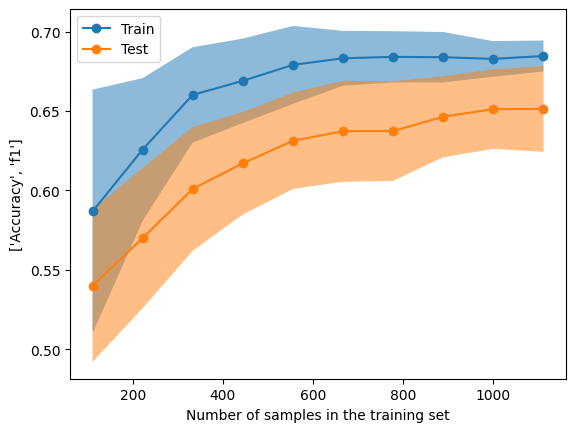

In [28]:
model_quality = dict()
common_params = {
    "X": train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": ["Accuracy", 'f1'],
}

for estimator in [lr_pred]:
    model_quality[estimator.__class__.__name__] = dict()
    learning_curve = LearningCurveDisplay.from_estimator(estimator, **common_params)
    model_quality[estimator.__class__.__name__]['train_scores'] = learning_curve.train_scores.mean(axis = 1)
    model_quality[estimator.__class__.__name__]['test_scores'] = learning_curve.test_scores.mean(axis = 1)
    model_quality[estimator.__class__.__name__]['train_sizes'] = learning_curve.train_sizes

In [93]:
model_quality['XGBRegressor']

{'train_scores': array([0.04592452, 0.07183721, 0.09122106, 0.10198845, 0.11072992,
        0.11896716, 0.12745956, 0.13360336, 0.13646264, 0.14173895]),
 'test_scores': array([-0.00650935,  0.0064752 ,  0.02042037,  0.03338824,  0.04338699,
         0.05163831,  0.06073067,  0.0678175 ,  0.07180502,  0.07708531]),
 'train_sizes': array([ 111,  222,  333,  444,  556,  667,  778,  889, 1000, 1112])}